# Usage of the Event Detector by Jorde and Jacobsen

# Load the required packages

In [18]:
# Import public packages
import sys
import os
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import glob
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from tensorflow.keras.backend import clear_session
# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_MEED
import BLUED_loader as blued

# Activate Autoreload
%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [19]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
TEST_MODEL_PATH = os.path.join("./BLUED_MEED_Test_Model/MEED_Test_Model")
DATASET = "blued_events" #name of the dataset (used to load the file later with my Utility class)
CURRENT_COLUMN = "Current B" # Dataset has two phases: phase A and B. They can be treated independently. We load only Phase B.
NETWORK_FREQUENCY_BLUED = 60 # Base electrical network frequency of the region where the dataset was recorded
SAMPLES_PER_SECOND_BLUED = NETWORK_FREQUENCY_BLUED # We compute two features (data points) per second.
SAMPLERATE_BLUED = 12000 # Sampling Rate the raw BLUED Dataset was recorded with 
WINDOW_SIZE_SECONDS = 10
window_size_samples = WINDOW_SIZE_SECONDS * SAMPLERATE_BLUED
# Compute the period size of the BLUED dataset: i.e. number of raw data points per period
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 

# Load and display the BLUED Test File

<IPython.core.display.Javascript object>


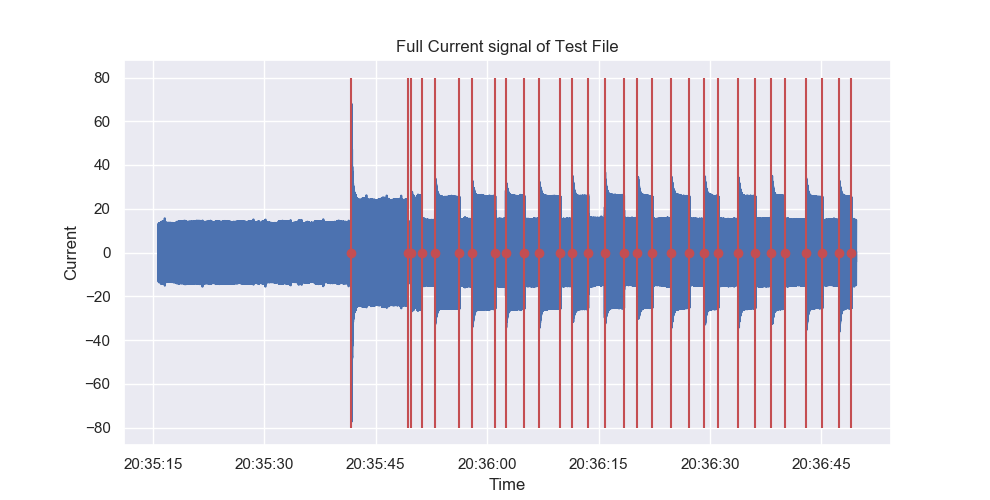

In [20]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data, file_info = blued.load_file(test_file)

lable_path:str = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.csv"))[0]
data_start = file_info['file_start']
data_end = file_info['file_end']

labels = blued.load_labels(lable_path, data_start, data_end)

current = data["Current"]
voltage = data["Voltage"]

# Plot the data from the test File
_, ax = plt.subplots(figsize=(9.9,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=labels.index, color='r',ymin=-80, ymax=80, zorder=101)
plt.show()

# Run the Event Detection on the Test Data

In [21]:
found_events=[]
show_plots = False

# Step 1: Initialize  the Event Detector
# We hand over an already developed model to algorithm
# The other case, where such a model is not existent is shown below in this notebook
MEED = EventDet_MEED(model_location_p=TEST_MODEL_PATH, coarse_mse_threshold_p=2, signal_length_p=120, network_frequency_p=NETWORK_FREQUENCY_BLUED)

# Step 2: Fit the event detector on some portions of the data
MEED.fit()

samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window
window_start_timestamp = file_info["file_start"] 

while samples_remaining >= window_size_samples: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + window_size_samples) # compute end index of the new window
    window_end_timestamp = window_start_timestamp + timedelta(seconds=WINDOW_SIZE_SECONDS)
    
    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]

    # Step 3: Use the feature computation function of the algorithm to compute the input features
    window_cumsum, window_rms = MEED.compute_input_signal(current_p=current_window, period_length_p=BLUED_period)
    
    if show_plots:
        plt.title("CUMSUM")
        plt.plot(window_cumsum)
        plt.show()
    
    # Step 4: Run the prediciton on the features
    events = MEED.predict(current_cumsum_p=window_cumsum, current_rms_p=window_rms, start_datetime_p=window_start_timestamp,use_median_p=False, cpu_only_p=True)

    if events is not None: # if an event is returned
        for event in events:
            print("Event Detected at " + str(event))
            found_events.append(str(event))


    # We start at the end of the previous window
    window_start = int(window_stop)
    window_start_timestamp = window_end_timestamp
  
    print("+++++++++++++++++++++++++++++++++++")
    
    # We need to update the data points that remain for streaming now.
    samples_remaining = samples_remaining - window_size_samples

+++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++
Event Detected at 2011-10-23 20:35:41.690166
+++++++++++++++++++++++++++++++++++
Event Detected at 2011-10-23 20:35:49.273499
Event Detected at 2011-10-23 20:35:49.856832
Event Detected at 2011-10-23 20:35:51.190166
Event Detected at 2011-10-23 20:35:53.023499
+++++++++++++++++++++++++++++++++++
Event Detected at 2011-10-23 20:35:56.273499
Event Detected at 2011-10-23 20:35:57.940166
Event Detected at 2011-10-23 20:36:01.106832
Event Detected at 2011-10-23 20:36:02.523499
Event Detected at 2011-10-23 20:36:05.023499
+++++++++++++++++++++++++++++++++++
Event Detected at 2011-10-23 20:36:07.023499
Event Detected at 2011-10-23 20:36:09.856832
Event Detected at 2011-10-23 20:36:11.523499
Event Detected at 2011-10-23 20:36:13.606832
+++++++++++++++++++++++++++++++++++
Event Detected at 2011-10-23 20:36:15.856832
Event Detected at 2011-10-23 20:36:18.440166
Event Detected at 2011-10-23 20:36:20.273499
Event Detected at 2

<IPython.core.display.Javascript object>


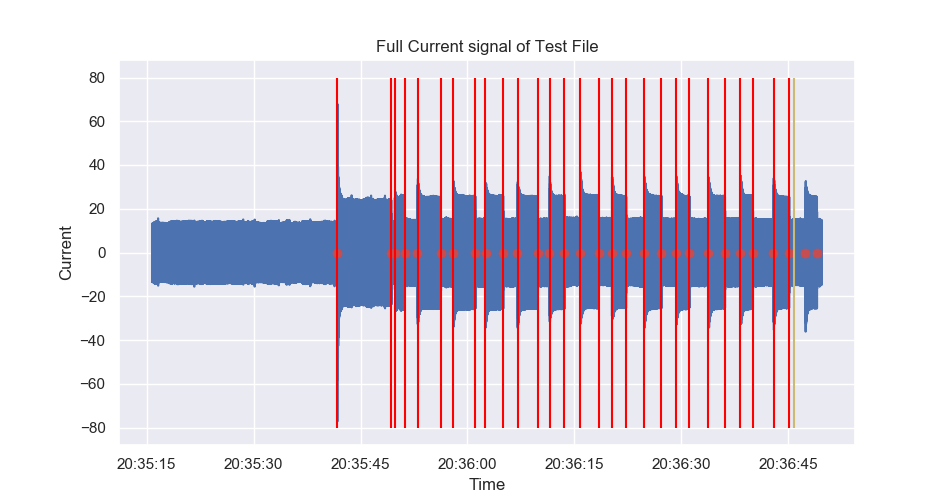

In [22]:
_, ax = plt.subplots(figsize=(9.5,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=found_events, color='red',ymin=-80, ymax=80, zorder=101)


#end of sliding window
ax.vlines(x=data.index[window_stop], color='y',ymin=-80, ymax=80, zorder=101)
plt.show()

# In case no MEED model has been trained before

In [15]:
clear_session() # to make the example run we have to clear the tensorflow sesssion first

#Step 1: Initialize  the Event Detector
# We hand over an already developed model to algorithm
# The other case, where such a model is not existent is shown below in this notebook
MEED = EventDet_MEED(model_location_p=TEST_MODEL_PATH, coarse_mse_threshold_p=2, signal_length_p=120, network_frequency_p=NETWORK_FREQUENCY_BLUED)

# Step 2: Fit the event detector on some portions of the data
MEED.fit(train_new_model_p=True)
keras_compiled_model = MEED.model
keras_compiled_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 120, 432)          376704    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 216)          467424    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 432)          748224    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 120, 1)            433       
Total params: 1,592,785
Trainable params: 1,592,785
Non-trainable params: 0
_________________________________________________________________
